# Imports

In [116]:
import requests
import json
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import ipywidgets as widgets
from ipyleaflet import Map, Marker


from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

RUN_FROM = 'uni_wifi' #'bastion'

if RUN_FROM == 'bastion' : URL, HEADERS = 'http://fission:31001/', None
if RUN_FROM == 'uni_wifi': URL, HEADERS =  'http://172.26.135.52:9090/', {'HOST': 'fission'}

WEATHER_NUM_COL = ['UV', 'Min Temp', 'Max Temp', 'WindSpeed', 'Min Humid', 'Max Humid', 'Rain', 'Pan-Rain', 'Evapo-Rain']

# Functions

In [117]:
def weather_to_pd(station_id: str, start_year: int, end_year: int, verb=False) -> pd.DataFrame:
    resp_dict = requests.get(URL+f'weather/{station_id}/{start_year}/{end_year}', headers=HEADERS).json()
    if verb : print(str(resp_dict)[:100])
    data = resp_dict['Data']
    if verb : print(f'Called weather api, fetched {len(data)} lines')
    return pd.DataFrame.from_records(data)

In [145]:
def get_stream_to_pd(api: str, station_id: str, size: int, radius_km: int, year=None, verb=False) -> pd.DataFrame:

    if year is None :
        resp_dict = requests.get(URL+api+f'/{station_id}/{size}/{radius_km}',
                                 headers=HEADERS).json()
    else :
        resp_dict = requests.get(URL+api+f'/{station_id}/{size}/{radius_km}',
                                 params=f'year={year}', headers=HEADERS).json()
    if verb : print(str(resp_dict)[:100])

    count=0
    status, token, new_data = resp_dict['Status'], resp_dict['Token'], resp_dict['Data']
    data = [new_data[i]['_source'] for i in range(len(new_data))]
    if verb : print(f'Called {api} api, fetched {len(new_data)} lines')


    while (status == 200) and (new_data != []) :
        count+=1
        resp_dict = json.loads(requests.get(URL+f'stream/'+token, headers=HEADERS).text)
        status, token, new_data = resp_dict['Status'], resp_dict['Token'], resp_dict['Data']
        if verb : print(f'Called stream {count} times, fetched {len(new_data)} new lines')
        data += [new_data[i]['_source'] for i in range(len(new_data))]

    if verb: print(f'Fetched a total of {len(data)}lines')
    return pd.DataFrame.from_records(data)

In [119]:
def clean_weather_pd(df_weather_full):
    df_weather = df_weather_full.copy()

    for col in WEATHER_NUM_COL:
        df_weather[col] = pd.to_numeric(df_weather[col])

    df_weather = df_weather.rename(columns={'Date':'date'})
    df_weather['date'] = pd.to_datetime(df_weather['date'], format='%d/%m/%Y').dt.date
    df_weather = df_weather.drop(columns=['created_at','source', 'Station Name'])

    return df_weather

In [120]:
def clean_crime_df(df_crime_full):
    df_crime = df_crime_full.groupby(['reported_date', 'description_1'])['offence_count'].sum().reset_index()

    df_crime = df_crime.rename(columns={'reported_date':'date'})
    df_crime['date'] = pd.to_datetime(df_crime['date']).dt.date

    return df_crime

In [190]:
def get_prediction_from_api(model_name, values):
    params = {'predictors': ','.join(map(str, values))}
    response = requests.get(URL+f'models/{model_name}', params=params)
    return response

# Welcome to IISTGO

![title](img/isitsafe_banner.webp)

### Where do you live?

In [133]:
# Choose your position
center = (-38., 145.)
mm = Map(center=center, zoom=6)
marker = Marker(location=center, draggable=True)
mm.add(marker)
display(mm)

Map(center=[-38.0, 145.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [180]:
#Choose your radius for study
slider = widgets.FloatSlider(description='Radius in km', min=0, max=700)
slider.value = 50
widgets.VBox([slider])

In [209]:
# Summary of the study
LOCATION = marker.location
RADIUS = slider.value

resp = requests.get(URL+f'stations/{LOCATION[1]}/{LOCATION[0]}').json()
STATION_ID = resp['Data']['Station ID']

print(f'Chosen Coordinates: {LOCATION}')
print(f'Chosen study radius: {RADIUS} km')
print(f'Closest weather station name and ID: {resp["Data"]["Station Name"]} {STATION_ID}')
print(f'Study conducted over the last ten years')

Chosen Coordinates: [-37.87485339352928, 144.95321321522414]
Chosen study radius: 569.4 km
Closest weather station name and ID: St Kilda Harbour RMYS 86220
Study conducted over the last ten years


### General trends over the last year

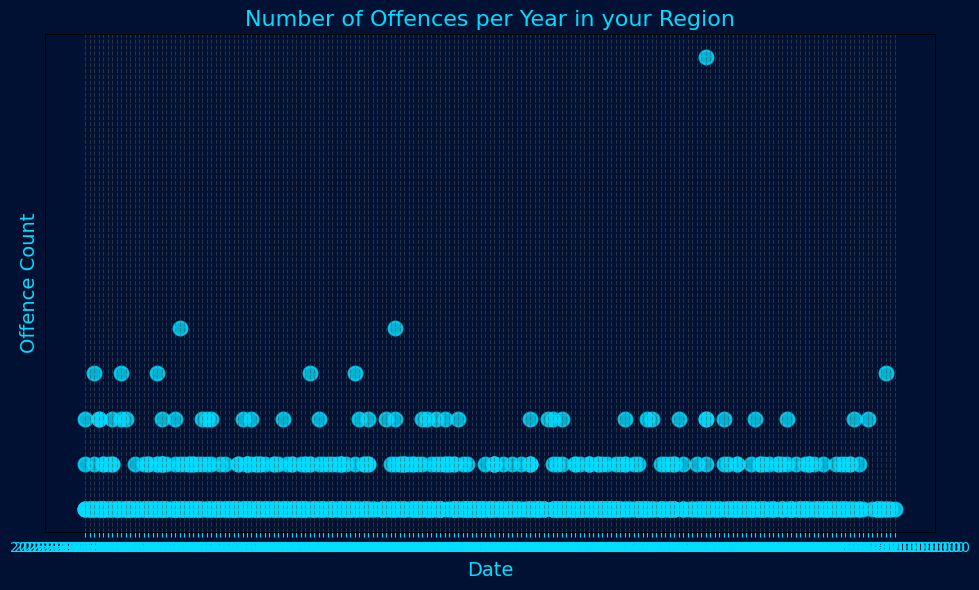

In [211]:
df_crime_full_y.groupby(['reported_date'])['offence_count'].sum().reset_index()

y = pd.to_datetime(df_crime_full_y['offence_count'])
x = df_crime_full_y['reported_date']

# Create a scatter plot
plt.figure(figsize=(10, 6), facecolor='#001133')  # Set the figure size and background color
ax = plt.gca()  # Get current axis
ax.set_facecolor('#001133')  # Set the background color for the plot area

plt.scatter(x, y, color='#00DDFF', edgecolor='#00DDFF', s=100, alpha=0.8, linewidth=1.5)
plt.title('Number of Offences per Year in your Region', fontsize=16, color='#00DDFF')
plt.xlabel('Date', fontsize=14, color='#00DDFF')
plt.ylabel('Offence Count', fontsize=14, color='#00DDFF')
ax.tick_params(axis='x', colors='#00DDFF')
ax.tick_params(axis='y', colors='#00DDFF')
plt.grid(True, linestyle='--', color='#555555', alpha=0.5)
plt.tight_layout()
plt.show()

### Does Weather impacts Crimes in your area

In [185]:
# Fetching data and computing 
df_weather_full = weather_to_pd(station_id=STATION_ID, start_year=2014, end_year=2024, verb=True)
df_weather = clean_weather_pd(df_weather_full)
df_crime_full = get_stream_to_pd(api='crime', station_id=STATION_ID, size=8000, radius_km=RADIUS, verb=True)
df_crime = clean_crime_df(df_crime_full)
df = pd.merge(df_weather, df_crime, on='date', how='inner')

{'Status': 200, 'Data': [{'UV': '6.22', 'Max Humid': '91', 'created_at': '2024-05-17T00:41:37.845687
Called weather api, fetched 3648 lines
{'Status': 200, 'Token': 'FGluY2x1ZGVfY29udGV4dF91dWlkDnF1ZXJ5VGhlbkZldGNoBRZjQkFfMHB6Q1E5MjlNcXFHcm
Called crime api, fetched 8000 lines
Called stream 1 times, fetched 8000 new lines
Called stream 2 times, fetched 8000 new lines
Called stream 3 times, fetched 1079 new lines
Called stream 4 times, fetched 0 new lines
Fetched a total of 25079lines


In [188]:
df_pers = df[df['description_1'] == 'OFFENCES AGAINST THE PERSON']
df_pers = df_pers.drop(columns=['description_1', 'date', 'state'])

lin_model_pers = LinearRegression()
lin_model_pers.fit(df_pers.drop(columns='offence_count').values, df_pers['offence_count'])
pd.DataFrame({'Predictors': df_pers.columns[:-1], 'Coefficient': lin_model_pers.coef_})

,Predictors,Coefficient
0,UV,0.020749
1,Max Humid,0.002113
2,Min Temp,0.000772
3,WindSpeed,0.010774
4,Min Humid,0.003474
5,Rain,0.002910
6,Pan-Rain,0.012349
7,Max Temp,0.014014
8,Evapo-Rain,-0.051568


In [201]:
import numpy as np
lin_model_pers.predict(np.array([1.1, 2.2, 1.1, 2.8,.1, 2.2,1.1, 2.2,1.1]).reshape(1,-1))

array([1.38109025])

### Get predictions 

In [189]:
with open(f'lin_model_crime_pers_VIC.pkl', 'wb') as f:
    pickle.dump(lin_model_pers, f)

In [198]:
# Get predictions
values = [3.1, -1.1]
response = get_prediction_from_api('lin_reg_model_test', values)
print(response.text)

{"prediction":3.9000000000000026}

